# Data loading

In [2]:
!pip install -q fastplot

In [3]:
import pandas as pd
import os
from IPython.display import clear_output
import numpy as np
import fastplot
%matplotlib inline
from datetime import timedelta, datetime
import ipywidgets as widgets
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

In [4]:
from scripts import dataset_creation 

THRESHOLD = 0.7
storage_path = './datasets'
dataset_creation.init(THRESHOLD, storage_path)

In [5]:
def update_paths(selected_dataset):
    global path_dataset, path_highest_epss_csv
    global cut_date
    global version
    cut_date = '2021-04-15'
    if selected_dataset == datasets[0]:
        path_dataset = os.path.join(storage_path, 'dataset.pkl')
        path_highest_epss_csv = os.path.join(storage_path, 'dataset_highest.pkl')
        version = 'full'
    elif selected_dataset == datasets[1]:
        path_dataset = os.path.join(storage_path, 'epss_v2.pkl')
        path_highest_epss_csv = os.path.join(storage_path, 'epss_v2_highest.pkl')
        version = 'v2'
    elif selected_dataset == datasets[2]:
        path_dataset = os.path.join(storage_path, 'epss_v3.pkl')
        path_highest_epss_csv = os.path.join(storage_path, 'epss_v3_highest.pkl')
        cut_date = '2023-03-07'
        version = 'v3'


datasets = ['EPSS v2 and EPSS v3', 'EPSS v2 only', 'EPSS v3 only']
dropdown_menu = widgets.Dropdown(
    options=datasets,
    value=datasets[2],
    description='Dataset:',
)
widgets.interactive(update_paths, selected_dataset=dropdown_menu)

interactive(children=(Dropdown(description='Dataset:', index=2, options=('EPSS v2 and EPSS v3', 'EPSS v2 only'…

In [6]:
df_dataset = pd.read_pickle(path_dataset)
df_highest_epss = pd.read_pickle(path_highest_epss_csv)

In [7]:
path_cve_info = os.path.join(storage_path, 'cve_info.csv')
with open(path_cve_info, 'r') as f:
    df_cve_info = pd.read_csv(f)
df_cve_info['published'] = pd.to_datetime(df_cve_info['published'])
df_cve_info = df_cve_info.sort_values(by=['published'])
historical_cve = df_cve_info[df_cve_info['published'] < cut_date]['id'].values
current_cve = df_cve_info[df_cve_info['published'] >= cut_date]['id'].values

In [8]:
df_dataset_historical = df_dataset[df_dataset['cve'].isin(historical_cve)]
df_dataset_current = df_dataset[df_dataset['cve'].isin(current_cve)]

df_highest_epss_historical = df_highest_epss[df_highest_epss['cve'].isin(historical_cve)]
df_highest_epss_current = df_highest_epss[df_highest_epss['cve'].isin(current_cve)]

df_pz_sheet, cve_pz = dataset_creation.download_dataset_and_extract_cve_pz()
df_pz = df_dataset[df_dataset['cve'].isin(cve_pz)]
df_pz_historical = df_dataset[df_dataset['cve'].isin(cve_pz) & df_dataset['cve'].isin(historical_cve)]
df_pz_current = df_dataset[df_dataset['cve'].isin(cve_pz) & df_dataset['cve'].isin(current_cve)]

df_kev_sheet, cve_kev = dataset_creation.download_dataset_and_extract_cve_kev()
df_kev = df_dataset[df_dataset['cve'].isin(cve_kev)]
df_kev_historical = df_dataset[df_dataset['cve'].isin(cve_kev) & df_dataset['cve'].isin(historical_cve)]
df_kev_current = df_dataset[df_dataset['cve'].isin(cve_kev) & df_dataset['cve'].isin(current_cve)]

## Definition of labels

We will use the following naming definition for each dataset. Each dataset name will contain the string `nvd_$version` where `$version` can be:
- `full`: full period from 15/04/2023 to 20/02/2024
- `v2`: from 15/04/2021 to 06/03/2023 (EPSS v2)
- `v3`: from 07/03/2023 to 20/02/2024 (EPSS v3)

Note that the date of 15/04/2021 is the first date on which a file containing the EPSS ranking was made available, while the date of 20/02/2024 is the last update of the dataset in use.

If the dataset is a subset derived from a particular CVEs list (e.g. Google Project Zero), instead of the string `nvd` there will be a string representing the name of the entity that made this list of CVEs available, which in our case are:
- `pz` that stays for Google Project Zero
- `kev` that stays for CISA KEV catalog
- `htb` that stays for hackthebox website

Since we need to distinguish between CVEs published before and after the release of different EPSS models, we introduce the **cut date**, i.e. the date of introduction of a model, 04/15/21 for EPSS v2 and 03/07/2023 for EPSS v3. Given this definition, we can say that all CVEs prior to (but excluding) the cut date are **historical** and those prior to (and including) are **current**. This difference will be reflected in the name in the last part of the same, where there will be an `h` if the dataset is composed of historical CVEs, a `c` if the CVEs are current.

Finally, if the dataset contains only CVEs that have or have not reached the T threshold at least once, there will be a final `>T`/`<=T` part of the name to reflect this characteristic. Note that there may be a `g` (growing) at the end of the name, indicating CVEs that have crossed the threshold at least once, but which were not born directly above it.

To exemplify, if we consider the dataset composed of Google Project Zero CVEs, using EPSS v3, and only the historical ones that have reached the threshold at least once, the name of this dataset (which will be present within the plots and in the possible descriptions) will be: `pz_v3,h,>T`.

In [9]:
# Labels
label_df_dataset = f"nvd_{version}"
label_df_dataset_historical = f"nvd_{version},h"
label_df_dataset_current = f"nvd_{version},c"

label_df_highest_epss = f"nvd_{version},>T"
label_df_highest_epss_historical = f"nvd_{version},h,>T"
label_df_highest_epss_current = f"nvd_{version},c,>T"

label_df_pz = f"pz_{version}"
label_df_pz_historical = f"pz_{version},h"
label_df_pz_current = f"pz_{version},c"

label_df_kev = f"kev_{version}"
label_df_kev_historical = f"kev_{version},h"
label_df_kev_current = f"kev_{version},c"

# Analyses

In [20]:
def plot_double_timeseries(index, ldata, rdata, llabel, rlabel):
    fig, ax1 = plt.subplots(figsize=(6, 3))
    ax1.plot(index, ldata, color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(llabel, color='b')
    ax1.tick_params('y', colors='b')
    ax1.grid(True, linestyle='--', linewidth=0.5, color='gray')

    ax2 = ax1.twinx()
    ax2.plot(index, rdata, color='r')
    ax2.set_ylabel(rlabel, color='r')
    ax1.set_xlim(left=index.min(), right=index.max())
    ax2.tick_params('y', colors='r')
    plt.setp(ax1.get_xticklabels(), rotation=30)
    fig.tight_layout()

## Cardinality

### Number of CVEs

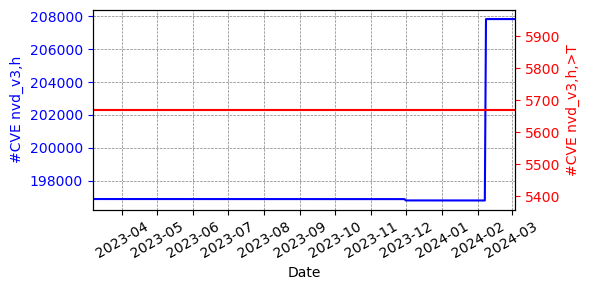

In [21]:
ldata = df_dataset_historical.groupby('date').size()
rdata = df_highest_epss_historical.groupby('date').size()
plot_double_timeseries(ldata.index, ldata, rdata, f"#CVE {label_df_dataset_historical}", 
                       f"#CVE {label_df_highest_epss_historical}")

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

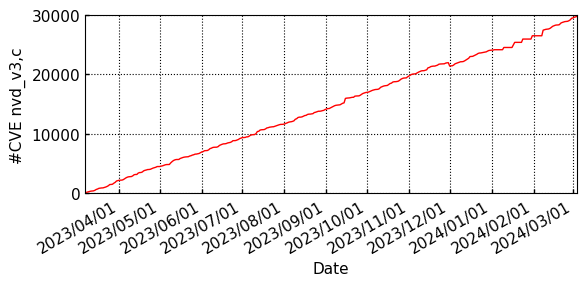

In [22]:
fastplot.plot(df_dataset_current.groupby('date').size(), None, mode='timeseries', xlabel='Date', 
              figsize=(6, 3), ylabel=f"#CVE {label_df_dataset_current}", xticks_rotate=30, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

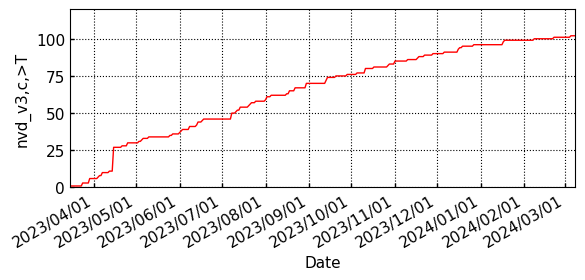

In [13]:
fastplot.plot(df_highest_epss_current.groupby('date').size(), None, mode='timeseries', xlabel='Date', 
              figsize=(6, 3), ylabel=f"{label_df_highest_epss_current}", xticks_rotate=30, grid=True)

In [25]:
print("Number of unique CVEs for each dataframe")
print(f"{label_df_dataset}: {len(df_dataset.groupby('cve'))}")
print(f"{label_df_dataset_historical}: {len(df_dataset_historical.groupby('cve'))}")
print(f"{label_df_dataset_current}: {len(df_dataset_current.groupby('cve'))}")
print(f"{label_df_highest_epss}: {len(df_highest_epss.groupby('cve'))}")
print(f"{label_df_highest_epss_historical}: {len(df_highest_epss_historical.groupby('cve'))}")
print(f"{label_df_highest_epss_current}: {len(df_highest_epss_current.groupby('cve'))}")
print(f"{label_df_pz}: {len(df_pz.groupby('cve'))}")
print(f"{label_df_pz_historical}: {len(df_pz_historical.groupby('cve'))}")
print(f"{label_df_pz_current}: {len(df_pz_current.groupby('cve'))}")
print(f"{label_df_kev}: {len(df_kev.groupby('cve'))}")
print(f"{label_df_kev_historical}: {len(df_kev_historical.groupby('cve'))}")
print(f"{label_df_kev_current}: {len(df_kev_current.groupby('cve'))}")

Number of unique CVEs for each dataframe
nvd_v3: 238552
nvd_v3,h: 207926
nvd_v3,c: 30584
nvd_v3,>T: 5772
nvd_v3,h,>T: 5671
nvd_v3,c,>T: 101
pz_v3: 310
pz_v3,h: 258
pz_v3,c: 52
kev_v3: 1086
kev_v3,h: 946
kev_v3,c: 140


### Missing dates

In [9]:
dates = df_dataset['date'].unique()
dates_range = pd.date_range(start=dates.min(), end=dates.max(), freq='D')
missing_dates = dates_range.difference(dates)
print('Missing dates:')
missing_dates_list = []
for e in missing_dates:
    missing_dates_list.append(str(e).split(' ')[0])
if missing_dates_list == []:
    print('No date missing')
else:
    for e in missing_dates_list:
        print(e)

Missing dates:
No date missing


In [10]:
cve_pz_list = df_pz['cve'].unique().tolist()
cve_kev_list = df_kev['cve'].unique().tolist()
print('CVEs of Google Project Zero not inside the CISA KEV')
for e in cve_pz_list:
    if not e in cve_kev_list:
        print(e)

CVEs of Google Project Zero not inside the CISA KEV
CVE-2020-6453
CVE-2023-21768
CVE-2017-1274


## Mean EPSS day by day

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

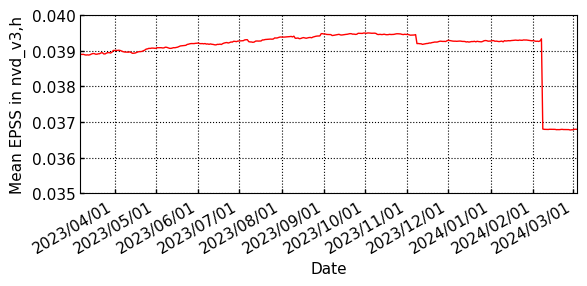

In [59]:
mean_epss = df_dataset_historical.groupby('date')['epss'].mean()
fastplot.plot(mean_epss, None, mode='timeseries', xlabel='Date', figsize=(6, 3), ylim=(0.035, 0.040),
              ylabel=f"Mean EPSS in {label_df_dataset_historical}", xticks_rotate=30, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

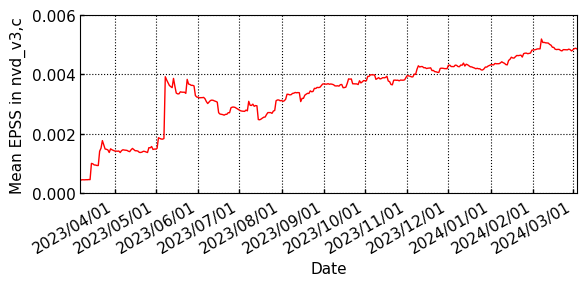

In [29]:
mean_epss = df_dataset_current.groupby('date')['epss'].mean()
fastplot.plot(mean_epss, None, mode='timeseries', xlabel='Date', figsize=(6, 3),
              ylabel=f"Mean EPSS in {label_df_dataset_current}", xticks_rotate=30, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

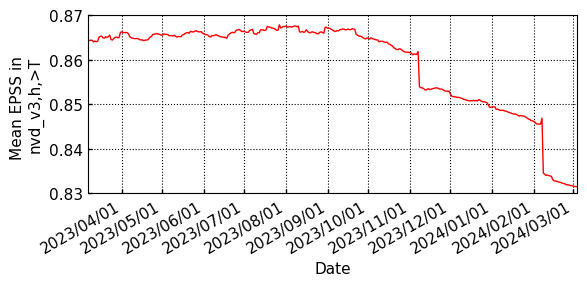

In [30]:
mean_epss = df_highest_epss_historical.groupby('date')['epss'].mean()
fastplot.plot(mean_epss, None, mode='timeseries', xlabel='Date', figsize=(6, 3),
              ylabel=f"Mean EPSS in \n{label_df_highest_epss_historical}", xticks_rotate=30, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

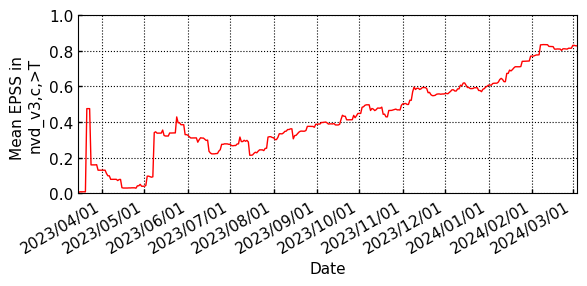

In [31]:
mean_epss = df_highest_epss_current.groupby('date')['epss'].mean()
fastplot.plot(mean_epss, None, mode='timeseries', xlabel='Date', figsize=(6, 3),
              ylabel=f"Mean EPSS in \n{label_df_highest_epss_current}", xticks_rotate=30, grid=True)

## Number of CVE with EPSS > threshold day by day

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

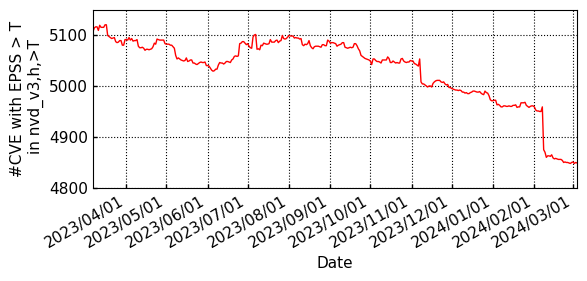

In [32]:
cve_high_counter = df_highest_epss_historical.groupby('date')['epss'].apply(lambda e: len([v for v in e.values if v > 0.7]))
fastplot.plot(cve_high_counter, None, mode='timeseries', xlabel='Date', figsize=(6, 3), 
              ylabel=f"#CVE with EPSS > T\n in {label_df_highest_epss_historical}", xticks_rotate=30, grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

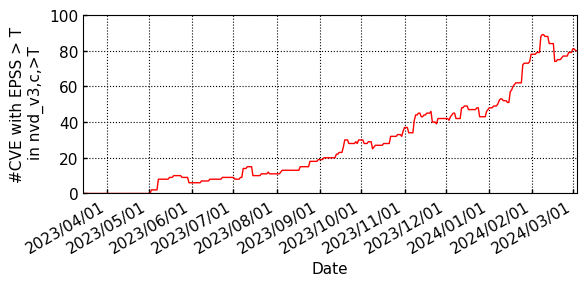

In [33]:
cve_high_counter = df_highest_epss_current.groupby('date')['epss'].apply(lambda e: len([v for v in e.values if v > 0.7]))
fastplot.plot(cve_high_counter, None, mode='timeseries', xlabel='Date', figsize=(6, 3), 
              ylabel=f"#CVE with EPSS > T\n in {label_df_highest_epss_current}", xticks_rotate=30, grid=True)

## Initial EPSS

In [34]:
def compute_first_epss(df):
    return df.groupby('cve')['epss'].apply(lambda l: l.values[0])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

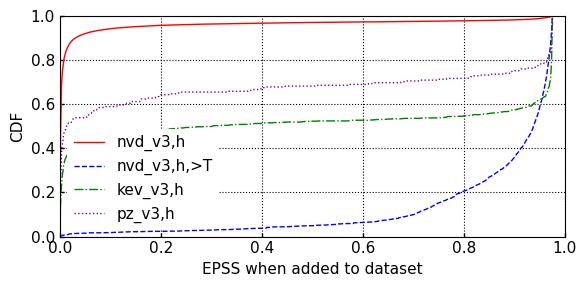

In [35]:
data = [(label_df_dataset_historical, compute_first_epss(df_dataset_historical)),
        (label_df_highest_epss_historical, compute_first_epss(df_highest_epss_historical)),
        (label_df_kev_historical, compute_first_epss(df_kev_historical)),
        (label_df_pz_historical, compute_first_epss(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.0, 1), grid=True, xlabel='EPSS when added to dataset', legend=True,
              figsize=(6, 3))

In [110]:
highest_cves_under_threshold = df_highest_epss_historical.groupby('cve')['epss'].apply(lambda l: l.values[0]).where(lambda x: x <= THRESHOLD).dropna()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

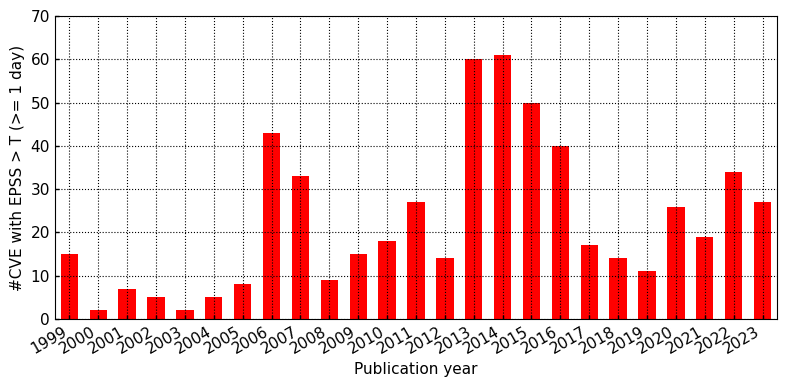

In [141]:
data = []
for year in range(1999, 2024):
    counter = count_entries_for_year(highest_cves_under_threshold, year)
    data.append([str(year), counter])
fastplot.plot(data, None, mode='bars', xlabel='Publication year',
              ylabel='#CVE with EPSS > T (>= 1 day)', xticks_rotate=30, figsize=(8, 4), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

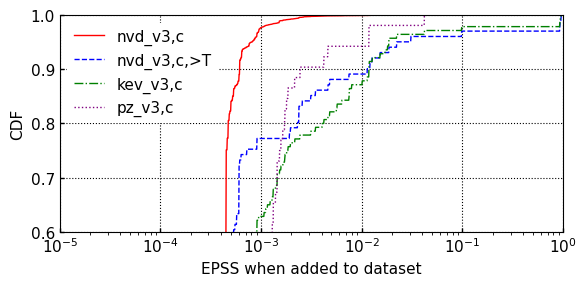

In [83]:
data = [(label_df_dataset_current, compute_first_epss(df_dataset_current)),
        (label_df_highest_epss_current, compute_first_epss(df_highest_epss_current)),
        (label_df_kev_current, compute_first_epss(df_kev_current)),
        (label_df_pz_current, compute_first_epss(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.00001, 1), ylim=(0.6, 1.0), grid=True, xlabel='EPSS when added to dataset', legend=True,
              figsize=(6, 3), xscale='log')

## Maximum EPSS

In [37]:
def compute_max_epss(df):
    return df.groupby('cve')['epss'].apply(lambda l: l.values.max())

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

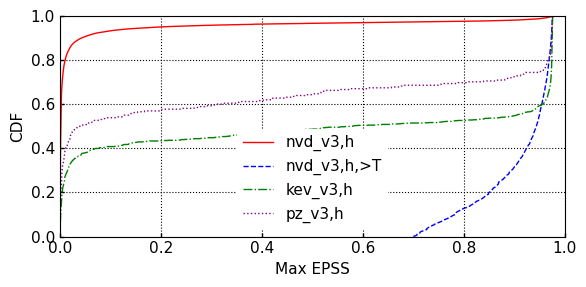

In [38]:
data = [(label_df_dataset_historical, compute_max_epss(df_dataset_historical)),
        (label_df_highest_epss_historical, compute_max_epss(df_highest_epss_historical)),
        (label_df_kev_historical, compute_max_epss(df_kev_historical)),
        (label_df_pz_historical, compute_max_epss(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.0, 1), grid=True, xlabel='Max EPSS', legend=True, figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

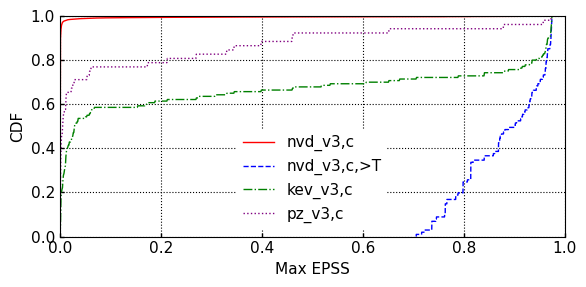

In [39]:
data = [(label_df_dataset_current, compute_max_epss(df_dataset_current)),
        (label_df_highest_epss_current, compute_max_epss(df_highest_epss_current)),
        (label_df_kev_current, compute_max_epss(df_kev_current)),
        (label_df_pz_current, compute_max_epss(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', xlim=(0.0, 1), grid=True, xlabel='Max EPSS', legend=True, figsize=(6, 3))

## Time for exceeding EPSS threshold

In [40]:
def get_days_before_threshold(series):
    indices_above_threshold = [i for i, v in enumerate(series.values) if v > THRESHOLD]
    return indices_above_threshold[0] if indices_above_threshold else np.nan


def get_days_before_threshold_new(series):
    indices_above_threshold = [i for i, v in enumerate(series.values) if v <= THRESHOLD]
    return len(indices_above_threshold) if indices_above_threshold else np.nan


def compute_days_needed_to_reach_threshold(df):
    return df.groupby('cve')['epss'].apply(get_days_before_threshold_new).dropna()

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

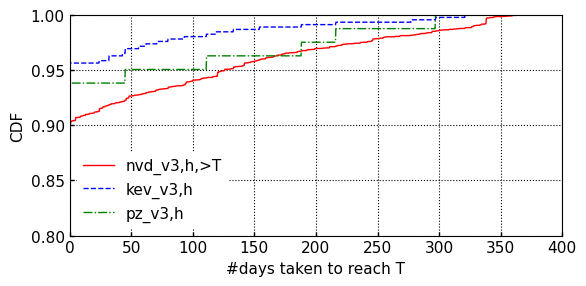

In [41]:
data = [(label_df_highest_epss_historical, compute_days_needed_to_reach_threshold(df_highest_epss_historical)),
        (label_df_kev_historical, compute_days_needed_to_reach_threshold(df_kev_historical)),
        (label_df_pz_historical, compute_days_needed_to_reach_threshold(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, ylim=(0.8, 1), xlabel='#days taken to reach T', 
              legend=True, figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

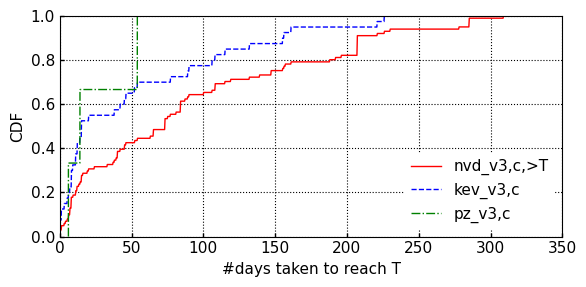

In [42]:
data = [(label_df_highest_epss_current, compute_days_needed_to_reach_threshold(df_highest_epss_current)),
        (label_df_kev_current, compute_days_needed_to_reach_threshold(df_kev_current)),
        (label_df_pz_current, compute_days_needed_to_reach_threshold(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days taken to reach T', legend=True, figsize=(6, 3))

## Number of days exceeding EPSS threshold

In [43]:
def compute_days_above_T(df):
    return df.groupby('cve')['epss'].apply(lambda s: len([e for e in s.values if e > THRESHOLD]))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

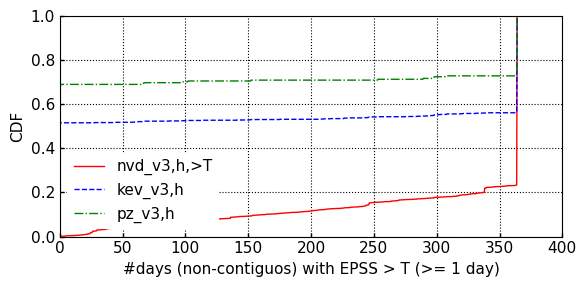

In [44]:
data = [(label_df_highest_epss_historical, compute_days_above_T(df_highest_epss_historical)),
        (label_df_kev_historical, compute_days_above_T(df_kev_historical)),
        (label_df_pz_historical, compute_days_above_T(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days (non-contiguos) with EPSS > T (>= 1 day)',
              legend=True, figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

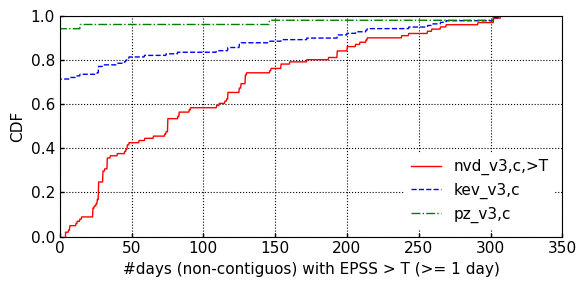

In [45]:
data = [(label_df_highest_epss_current, compute_days_above_T(df_highest_epss_current)),
        (label_df_kev_current, compute_days_above_T(df_kev_current)),
        (label_df_pz_current, compute_days_above_T(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#days (non-contiguos) with EPSS > T (>= 1 day)',
              legend=True, figsize=(6, 3))

## Maximum number of contiguous days exceeding EPSS threshold

In [14]:
def max_contiguous_days(dates):
    max_length = 1
    current_length = 1
    sorted_dates = sorted(dates)
    for i in range(1, len(sorted_dates)):
        if str(sorted_dates[i]) == '2022-07-15 00:00:00':
            current_length += 1
        elif sorted_dates[i] == sorted_dates[i - 1] + timedelta(days=1):
            current_length += 1
        else:
            current_length = 1
        max_length = max(max_length, current_length)
    return max_length


def compute_contiguos_days_above_T(df):
    epss_dates = df.groupby('cve')[['epss', 'date']].apply(
        lambda s: [d for e, d in zip(s['epss'].values, s['date'].values) if e > THRESHOLD])
    epss_dates_df = pd.DataFrame(epss_dates.items(), columns=['cve', 'dates'])
    epss_dates_df['dates'] = epss_dates_df['dates'].apply(lambda x: [pd.to_datetime(date) for date in x])
    return epss_dates_df['dates'].apply(max_contiguous_days)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

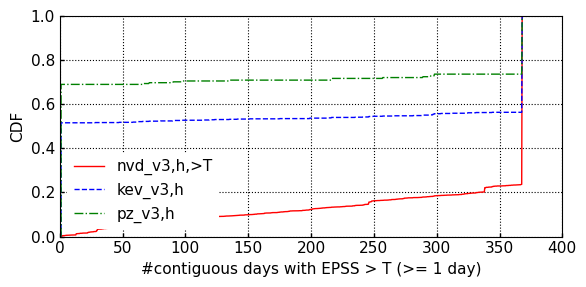

In [15]:
data = [(label_df_highest_epss_historical, compute_contiguos_days_above_T(df_highest_epss_historical)),
        (label_df_kev_historical, compute_contiguos_days_above_T(df_kev_historical)),
        (label_df_pz_historical, compute_contiguos_days_above_T(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#contiguous days with EPSS > T (>= 1 day)',
              legend=True, figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

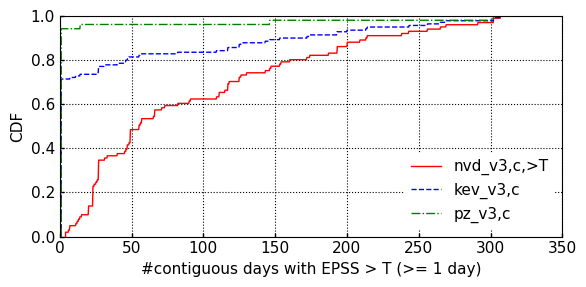

In [48]:
data = [(label_df_highest_epss_current, compute_contiguos_days_above_T(df_highest_epss_current)),
        (label_df_kev_current, compute_contiguos_days_above_T(df_kev_current)),
        (label_df_pz_current, compute_contiguos_days_above_T(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='#contiguous days with EPSS > T (>= 1 day)',
              legend=True, figsize=(6, 3))

## Percentage of days above the threshold wrt the life-time of the CVE

In [49]:
def compute_percentage_days_above_T_wrt_dataset_lifetime(df):
    return df.groupby('cve')['epss'].apply(lambda s: len([e for e in s.values if e > THRESHOLD]) / len(s.values) * 100)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

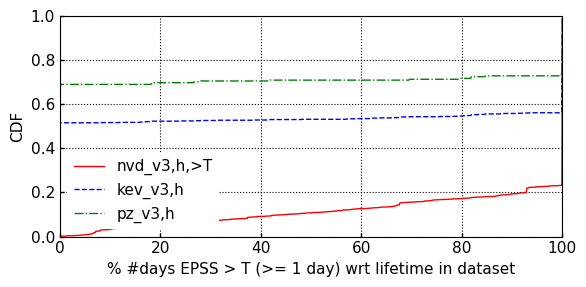

In [50]:
data = [(label_df_highest_epss_historical, compute_percentage_days_above_T_wrt_dataset_lifetime(df_highest_epss_historical)),
        (label_df_kev_historical, compute_percentage_days_above_T_wrt_dataset_lifetime(df_kev_historical)),
        (label_df_pz_historical, compute_percentage_days_above_T_wrt_dataset_lifetime(df_pz_historical))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='% #days EPSS > T (>= 1 day) wrt lifetime in dataset',
              legend=True, figsize=(6, 3))

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

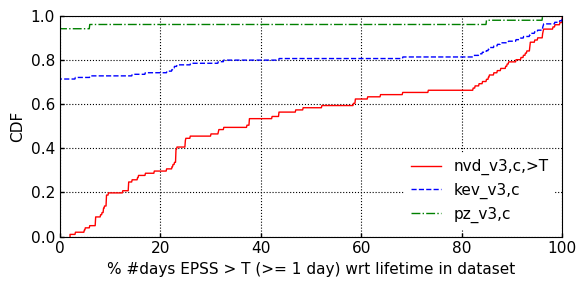

In [51]:
data = [(label_df_highest_epss_current, compute_percentage_days_above_T_wrt_dataset_lifetime(df_highest_epss_current)),
        (label_df_kev_current, compute_percentage_days_above_T_wrt_dataset_lifetime(df_kev_current)),
        (label_df_pz_current, compute_percentage_days_above_T_wrt_dataset_lifetime(df_pz_current))]
fastplot.plot(data, None, mode='CDF_multi', grid=True, xlabel='% #days EPSS > T (>= 1 day) wrt lifetime in dataset',
              legend=True, figsize=(6, 3))

## Number of CVEs that exceed the threshold vs year of publication

In [131]:
def subset_highest_epss_df_year(year):
    return df_highest_epss[df_highest_epss['date'].dt.year == year].groupby('cve')['epss'].apply(lambda l: l.values.max())


def count_entries_for_year(series, year):
    return sum(1 for cve, _ in series.items() if str(year) in cve.split('-')[1])

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

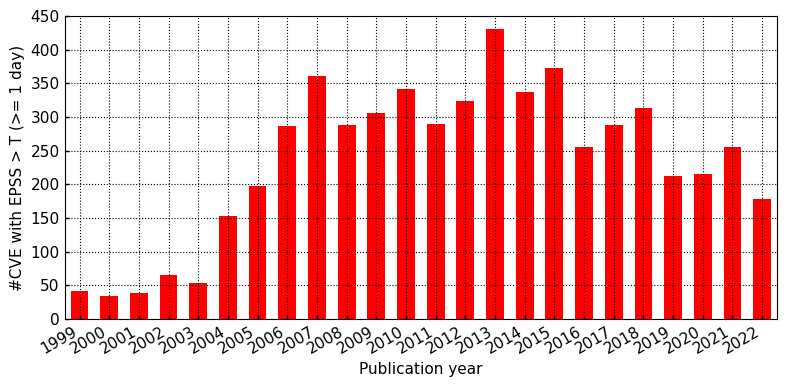

In [132]:
highest_epss = df_highest_epss_historical.groupby('cve')['epss'].apply(lambda l: l.values.max())
data = []
for year in range(1999, 2023):
    counter = count_entries_for_year(highest_epss, year)
    data.append([str(year), counter])
fastplot.plot(data, None, mode='bars', xlabel='Publication year',
              ylabel='#CVE with EPSS > T (>= 1 day)', xticks_rotate=30, figsize=(8, 4), grid=True)

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

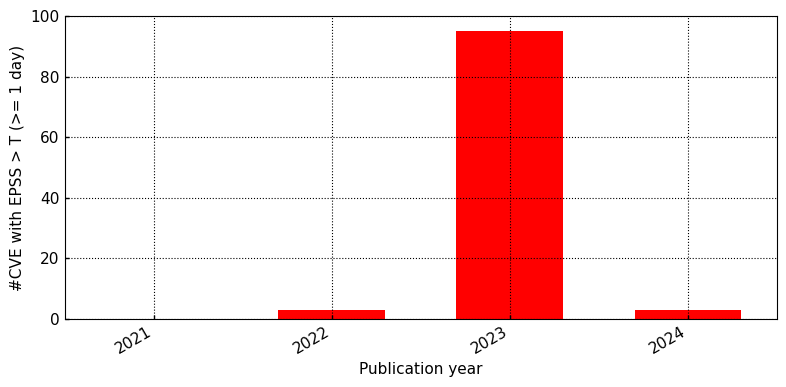

In [54]:
highest_epss = df_highest_epss_current.groupby('cve')['epss'].apply(lambda l: l.values.max())
data = []
for year in range(2021, 2025):
    counter = count_entries_for_year(highest_epss, year)
    data.append([str(year), counter])
fastplot.plot(data, None, mode='bars', xlabel='Publication year',
              ylabel='#CVE with EPSS > T (>= 1 day)', xticks_rotate=30, figsize=(8, 4), grid=True)

## Spearman correlation of day `i` and day `i-1` for the CVE that reached T at least one day

In [55]:
def compute_spearman_correlations(df):
    dates = df['date'].unique()
    correlations = []
    df_prev = df[df['date'] == dates[0]]
    for date in dates[1:]:
        df_curr = df[df['date'] == date]
        common_cve = np.intersect1d(df_prev['cve'], df_curr['cve'])
        df_prev_filtered = df_prev[df_prev['cve'].isin(common_cve)].sort_values(by='cve')
        df_curr_filtered = df_curr[df_curr['cve'].isin(common_cve)].sort_values(by='cve')
        correlation, _ = spearmanr(df_curr_filtered['epss'], df_prev_filtered['epss'])
        correlations.append((date, correlation))
        df_prev = df_curr
    return correlations

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

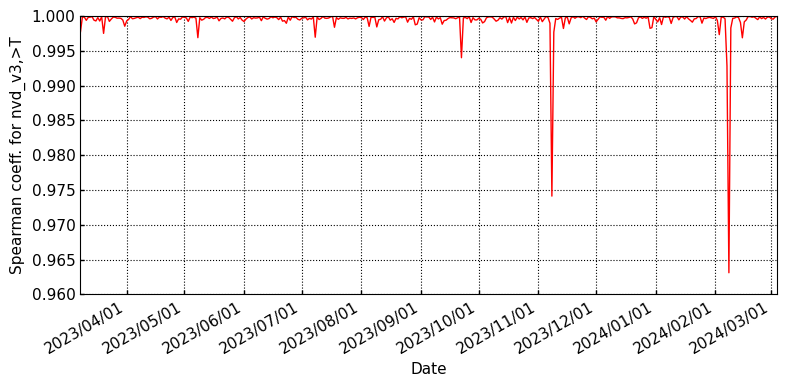

In [56]:
ts = pd.Series(dict(compute_spearman_correlations(df_highest_epss)))
date_from = pd.Timestamp(str(ts.index.min()).split(' ')[0])
date_to = pd.Timestamp(str(ts.index.max()).split(' ')[0])
fastplot.plot(ts, None, mode='timeseries', xlabel='Date', figsize=(8, 4), 
              ylabel=f"Spearman coeff. for {label_df_highest_epss}", xticks_rotate=30, 
              grid=True, xlim=(pd.Timestamp(date_from), pd.Timestamp(date_to)))

## Timeseries of CVEs what reached the threshold at least one time

In [11]:
from scripts import util

util.plot_cve_timeseries_of(df_highest_epss_current)

<Figure size 640x480 with 0 Axes>